# Predict customer churn

In this notebook we will build a model to predict, based on the available data, if a customer of a telecom company will churn. The dataset comes from an Iranian company, with each row representing a customer over a year period. Along with a churn label, there is information on the customers' activity, such as call failures and subscription length. 

**Questions:**
- 🗺️ **Explore**: Which age groups send more SMS messages than make phone calls?
- 📊 **Visualize**: Which category has the highest churn?

Finally, the telecom company wants to know whether you can use this data to predict whether a customer will churn. They also want to know what factors increase the probability that a customer churns.

We will use a well-known classification algorithm, the [k-nearest neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm), which simply look at the k closest labeled data point and takes a majority vote to classify new customers.

The notebook is organized as follows:
1. Exploratory analysis to clean and visualize the data
2. Data preprocessing
3. Building the model, test it and evaluate its performance.
4. Implement a pipeline that [explore different classifier](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py) and their performances.
5. Feature importance

[Source](https://www.kaggle.com/royjafari/customer-churn)  of dataset and [source](https://archive.ics.uci.edu/ml/datasets/Iranian+Churn+Dataset) of dataset description. 

**Citation**: Jafari-Marandi, R., Denton, J., Idris, A., Smith, B. K., & Keramati, A. (2020). Optimum Profit-Driven Churn Decision Making: Innovative Artificial Neural Networks in Telecom Industry. Neural Computing and Applications.

### 1. Exploratory analysis & cleaning

Let's start to explore the dataset. Following the [dataset description](https://www.kaggle.com/datasets/royjafari/customer-churn) the features represent:

- **Call Failure:** number (#) of failed calls. Either non-reachable or ring-no-reply.
- **Complains:** binary (0: No complaint, 1: complaint).
- **Subscription lenght:** total months of subscription.
- **Charge amount:** 1-10, proportional to the amount of money spent by the user
- **Seconds of Use:** total seconds of calls
- **Frequency of use:** calls/month
- **Frequency of SMS:** sms/month
- **Distinct Called Numbers:** total number of distinct phone calls
- **Tariff plan:** binary (1: Pay as you go, 2: contractual)
- **Age Group:** ordinal attribute (1: x<15, 2: 15<x<30, 3: 30<x<45, 4: 45<x<60,  5: x>60)
- **Age:** age of the customer
- **Status:** binary (1: active, 2: non-active)
- **Churn:** binary (1: churn, 0: non-churn) - Class label

Other features like `Customer Value`, `FN` and `FP` are the result of the analysis performed by the researchers when trying to infer the value of a customer from the company's point of view. We are not interested for now in their analysis so we can drop them.

We notice that we can also drop the `Age` feature since it is redundant with the `Age`, which only contains 5 different values.

In [15]:
import pandas as pd

#import the database
df = pd.read_csv("./Customer Churn.csv")

#drop irrelevant features
df=df.drop(columns=['Age','Customer Value','FN','FP'])

#rename columns for more compact labels
df=df.rename(columns={"Call  Failure": "call_fail",
                "Complains": "complains",
                "Subscription  Length":"sub_length",
                "Charge  Amount":"charge_amount",
                "Seconds of Use":"sec_of_use",
                "Frequency of use":"freq_calls",
                "Frequency of SMS":"freq_sms",
                "Distinct Called Numbers":"dist_call_num",
                "Tariff Plan":"tariff_plan",
                "Status":"status",
                "Age Group":"age_group",
                "Churn":"churn"})

#display the first few rows
display(df.head())

#display the info about the type and null values
df.info()

#display the basic statistics of the dataset
display(df.describe())

,call_fail,complains,sub_length,charge_amount,sec_of_use,freq_calls,freq_sms,dist_call_num,age_group,tariff_plan,status,churn
0,8,0,38,0,4370,71,5,17,3,1,1,0
1,0,0,39,0,318,5,7,4,2,1,2,0
2,10,0,37,0,2453,60,359,24,3,1,1,0
3,10,0,38,0,4198,66,1,35,1,1,1,0
4,3,0,38,0,2393,58,2,33,1,1,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   call_fail      3150 non-null   int64
 1   complains      3150 non-null   int64
 2   sub_length     3150 non-null   int64
 3   charge_amount  3150 non-null   int64
 4   sec_of_use     3150 non-null   int64
 5   freq_calls     3150 non-null   int64
 6   freq_sms       3150 non-null   int64
 7   dist_call_num  3150 non-null   int64
 8   age_group      3150 non-null   int64
 9   tariff_plan    3150 non-null   int64
 10  status         3150 non-null   int64
 11  churn          3150 non-null   int64
dtypes: int64(12)
memory usage: 295.4 KB


,call_fail,complains,sub_length,charge_amount,sec_of_use,freq_calls,freq_sms,dist_call_num,age_group,tariff_plan,status,churn
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,2.826032,1.077778,1.248254,0.157143
std,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,0.892555,0.267864,0.432069,0.363993
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,2.000000,1.000000,1.000000,0.000000
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,3.000000,1.000000,1.000000,0.000000
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,3.000000,1.000000,1.000000,0.000000
max,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,5.000000,2.000000,2.000000,1.000000


Luckily, the database has already been cleaned for us. No value is missing and categorical features are already in a numeric form. One important feature is for example that the churn rate in the dataset is close to 16%, which makes the two classes unbalanced. Of course a company would like the churn rate to be as low as possible.

##### a. Which age groups send more SMS messages than make phone calls?

As expected the highest frequencies of both SMS and calls are expected for people between 15 and 45 years old, which tends to have a bigger social and professional network. Within them people between 30 and 45 years old slightly tend to prefer sending SMS rather than calling. For practical reason, very young (<15) or very old (>60) tends to prefer calling. 

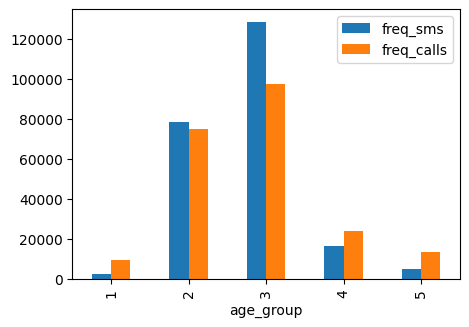

In [16]:
#group by the features by age group
df_by_age=df.groupby("age_group")[["freq_sms","freq_calls"]].sum()

#import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(1, 1, figsize = (5, 3.5))
df_by_age.plot(ax=ax,kind="bar");

#### b. Which category has the highest churn?

TODO

### 2. Feature selection

One important thing to understand is if there are some evident pattern/correlations in our data. We thus chose two simple visualizations

- **Correlation Matrix:** check for any evident linear relation between the features and the target variable.
- **Pair Plots:** check for any evident cluster in churn for pairs of features

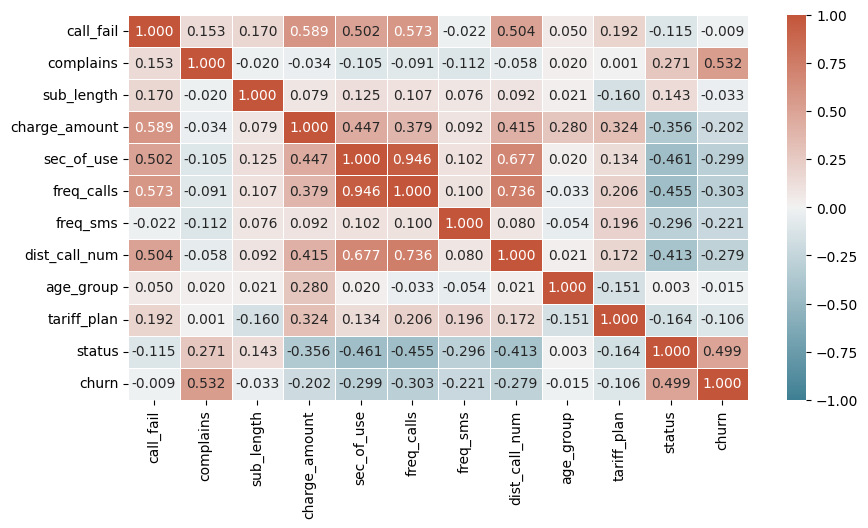

In [17]:
# calculate correlation
df_corr = df.corr()

#plot heatmap correlation matrix
plt.figure(figsize=(10,5))
sns.heatmap(df_corr,
            annot=True,
            fmt=".3f",
            vmin=-1,
            vmax=1, 
            linewidths=.5, 
            #cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
            cmap = sns.diverging_palette(220, 20, as_cmap=True)
            )
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [18]:
#select relevant columns for pairplot
cont_feature_col=['call_fail','sub_length','sec_of_use','freq_of_use','freq_of_sms','dist_call_num']

#pairplot
sns.pairplot(df[ cont_feature_col+['churn'] ], hue='churn', corner=True)
#sns.set(style="ticks")

KeyError: "['freq_of_use', 'freq_of_sms'] not in index"

### 3. Preprocessing the data

While the plots above are beautiful and does display some clustering behavior (although disconnected) it seems difficult to identify a general rule. This is typical in a multi-dimensional feature space and is the main reason to develop Machine Learning (ML) based classification models. Before jumping into that we need first to 

1. Split the data into a train and a test set for performance evaluation later
2. Preprocess the data to make it more digestible by ML models.

In [ ]:
#Arrays of the features and the target variable
X = df.drop('churn', axis=1).values
y = df['churn'].values

#Import tools to split data into train/test
from sklearn.model_selection import train_test_split

#Split data for train and test 
#   -stratify to capture the unbalance
#   -set a seed for reproducibility
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2, stratify=y,random_state=2023)

#scale the data
from sklearn.preprocessing import StandardScaler
X_train_scaled=StandardScaler().fit_transform(X_train)
X_test_scaled=StandardScaler().fit_transform(X_test)

#### KNN Classifier
To start, we will use one of the simplest supervised classifier, the k-nearest neighbor, which cluster data according to a majority rule.

When trained, the model display an accuracy of roughly 94%. Not bad! Notice that the number of nearest neighbor that the model includes is set `n_neighbors=5`, since it can be easily seen to be the optimal value.

In [ ]:
#import the classifier
from sklearn.neighbors import KNeighborsClassifier

#initialize the model
knn= KNeighborsClassifier(n_neighbors=5)

#fit the model
knn.fit(X_train_scaled,y_train)

#score
knn_score=knn.score(X_test_scaled,y_test)
print("KNN accuracy: "+f"{knn_score:.3}")


### 4. Exploring different classifiers

Here we implement a pipeline to compare different classifier and their performance
- [Gaussian Process](https://scikit-learn.org/stable/modules/gaussian_process.html)
- [Decision Tree](https://scikit-learn.org/stable/modules/tree.html#)
- [Random Forest](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees)

We take into account these models for their ability to deal with the convoluted clustering shown in paragraph 2, as opposed to linear classifiers. Already without any fine tuning, these models obtain similar performance compared to KNN. 


In [ ]:
#Import models
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

names = [
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
]

classifiers = [
    GaussianProcessClassifier(),
    DecisionTreeClassifier(random_state=2023),
    RandomForestClassifier(random_state=2023),
]

for name,classifier in zip(names,classifiers):
    mdl=classifier
    mdl.fit(X_train_scaled,y_train)
    print(name+" accuracy:"+f"{mdl.score(X_test_scaled,y_test):0.3}")

### 5. Feature Importance

Which features determines that a customer will churn?

To finish...